In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib
import matplotlib.pyplot as plt

In [69]:
img = cv2.imread("./data/scarlett_johansson/001_cb004eea.jpg")

In [70]:
img.shape

(568, 474, 3)

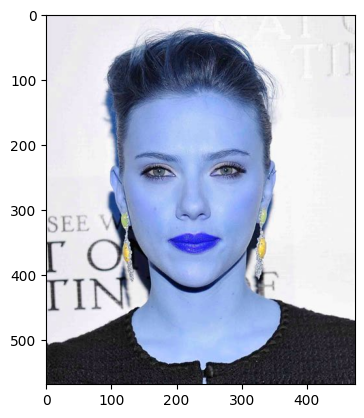

In [71]:
plt.imshow(img)

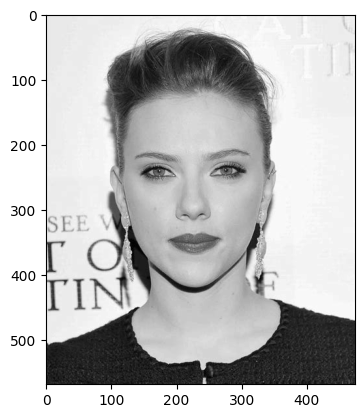

In [72]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

In [73]:
face_cascade = cv2.CascadeClassifier("./haar_cascade/haarcascade_frontalface_alt.xml")
eye_cascade = cv2.CascadeClassifier("./haar_cascade/haarcascade_eye.xml")

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 98, 145, 258, 258]], dtype=int32)

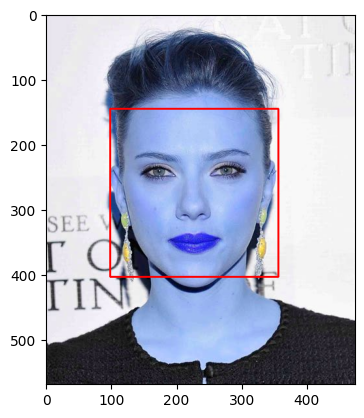

In [74]:
(x, y, w, h) = faces[0]
face_img = cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
plt.imshow(face_img)


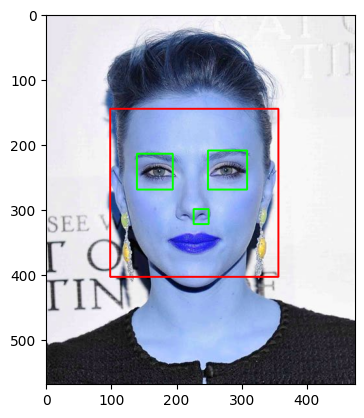

In [75]:
cv2.destroyAllWindows()

for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex,ey), (ex+ew, ey+eh), (0,255,0), 2)

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

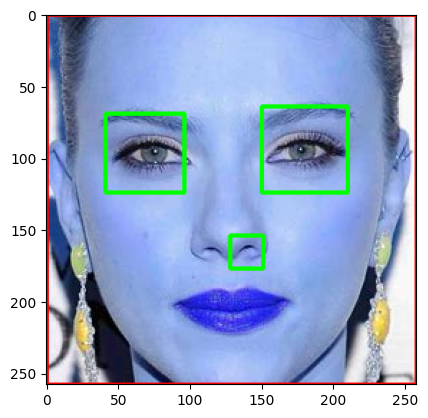

In [76]:
plt.imshow(roi_color, cmap='gray')

In [59]:
def get_img_if_2_eyes(img_path):
    img = cv2.imread(img_path)
    if img is not None:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,w,h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) >= 2:
                return roi_color


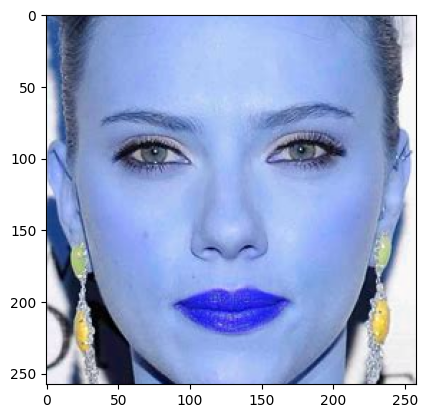

In [77]:
cropped_image = get_img_if_2_eyes("./data/scarlett_johansson/001_cb004eea.jpg")
plt.imshow(cropped_image)

Image is None


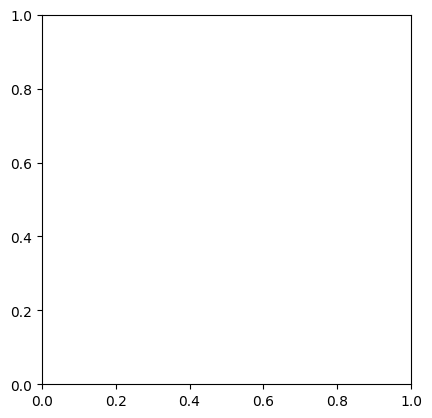

In [61]:
img_obstructed = get_img_if_2_eyes("./data/Scarlett Johansson/157_8843fa75.jpg")

try:
    plt.imshow(img_obstructed)
except:
    print('Image is None')

In [62]:
path_to_data = './data/'
path_to_cr = './data/cropped/'

In [63]:
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        name = entry.path.split('/')[-1]
        new_name = name.split(' ')[0].lower() + '_' + name.split(' ')[1].lower()
        os.rename(entry.path, path_to_data+new_name)
        print('Name of folder changed to: ', path_to_data+new_name)

Name of folder changed to:  ./data/angelina_jolie
Name of folder changed to:  ./data/jennifer_lawrence
Name of folder changed to:  ./data/natalie_portman
Name of folder changed to:  ./data/nicole_kidman
Name of folder changed to:  ./data/sandra_bullock
Name of folder changed to:  ./data/scarlett_johansson


In [64]:
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

img_dirs


['./data/angelina_jolie',
 './data/jennifer_lawrence',
 './data/natalie_portman',
 './data/nicole_kidman',
 './data/sandra_bullock',
 './data/scarlett_johansson']

In [65]:
import shutil

if os.path.exists(path_to_cr):
    shutil.rmtree(path_to_cr)
os.mkdir(path_to_cr)

In [66]:
cropped_image_dir = []
actor_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    name = img_dir.split('/')[-1]

    for entry in os.scandir(img_dir):
        roi_color = get_img_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr + name

            if not os.path.exists(cropped_folder):
                os.mkdir(cropped_folder)
                cropped_image_dir.append(cropped_folder)
                print('Generating cropped images in folder: ', cropped_folder)

            cropped_file_name = name + str(count) + '.png'
            cropped_file_path = cropped_folder + "/" + cropped_file_name

            cv2.imwrite(cropped_file_path, roi_color)

            try:
                actor_file_names_dict[name].append(cropped_file_path)
            except KeyError:
                actor_file_names_dict[name] = []
                actor_file_names_dict[name].append(cropped_file_path)
            
            count += 1


Generating cropped images in folder:  ./data/cropped/angelina_jolie
Generating cropped images in folder:  ./data/cropped/jennifer_lawrence
Generating cropped images in folder:  ./data/cropped/natalie_portman
Generating cropped images in folder:  ./data/cropped/nicole_kidman
Generating cropped images in folder:  ./data/cropped/sandra_bullock
Generating cropped images in folder:  ./data/cropped/scarlett_johansson


In [67]:
import pywt

def w2d(img, mode='haar', level=1):
    imArray = img
    imArray = cv2.cvtColor(imArray, cv2.COLOR_BGR2GRAY)
    imArray = np.float32(imArray)
    imArray /= 255

    coeffs = pywt.wavedec2(imArray, mode, level=level)

    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0

    imArray_H = pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H)

    return imArray_H

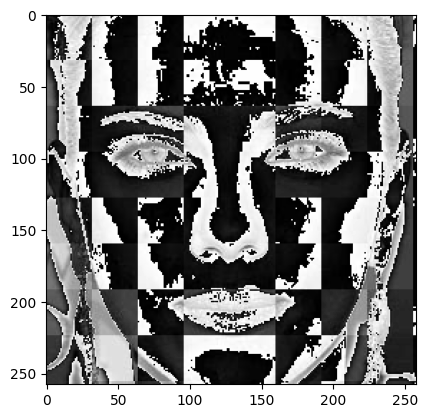

In [79]:
im_haar = w2d(cropped_image, 'db1', 5)
plt.imshow(im_haar, cmap='gray')

In [80]:
class_dict = {}
count = 0

for name in actor_file_names_dict.keys():
    class_dict[name] = count
    count += 1

class_dict

{'angelina_jolie': 0,
 'jennifer_lawrence': 1,
 'natalie_portman': 2,
 'nicole_kidman': 3,
 'sandra_bullock': 4,
 'scarlett_johansson': 5}

In [82]:
X = []
y = []

for name, files in actor_file_names_dict.items():
    for image in files:
        img = cv2.imread(image)
        scalled_raw_img = cv2.resize(img, (32,32))
        
        im_haar = w2d(img, 'db2', 3)
        scalled_im_haar = cv2.resize(im_haar, (32,32))

        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1), scalled_im_haar.reshape(32*32,1)))

        X.append(combined_img)
        y.append(class_dict[name])

In [83]:
len(X[0])

4096

In [84]:
X = np.array(X).reshape(len(X), 4096).astype(float)
X.shape

(580, 4096)

In [112]:
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [147]:
X_train.shape, X_test.shape

((522, 4096), (58, 4096))

In [148]:
algos = {
    'svm' : {
        'model' : svm.SVC(probability=True),
        'params' : {'svc__C' : [1,10,100],
                    'svc__kernel' : ['rbf', 'linear'],
                    'svc__gamma' : [0.01, 0.03, 0.1, 0.3, 1]}
    },
    'LogisticRegression' : {
        'model' : LogisticRegression(max_iter=10000),
        'params' : {'logisticregression__solver' : ['liblinear', 'newton-cg'], 'logisticregression__C' : [1,10,100]}
    },
    'xgboost' : {
        'model' : xgb.XGBClassifier(),
        'params' : {'xgbclassifier__booster' : ['gbtree'],
                    'xgbclassifier__eta' : [0.01, 0.03, 0.1, 0.3]}
    }
}

scores = []
best_estimator = {}

for name, config in algos.items():
    pipe = make_pipeline(StandardScaler(), config['model'])
    gs = GridSearchCV(pipe, config['params'], cv=5, return_train_score=False)
    gs.fit(X_train, y_train)
    
    scores.append({
        'model' : name,
        'best_score' : gs.best_score_,
        'best_params' : gs.best_params_
    })
    best_estimator[name] = gs.best_estimator_

pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

,model,best_score,best_params
0,svm,0.731813,"{'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel..."
1,LogisticRegression,0.756758,"{'logisticregression__C': 1, 'logisticregressi..."
2,xgboost,0.666520,"{'xgbclassifier__booster': 'gbtree', 'xgbclass..."


In [149]:
print(best_estimator['svm'].score(X_test, y_test))
print(best_estimator['LogisticRegression'].score(X_test, y_test))
print(best_estimator['xgboost'].score(X_test, y_test))

0.8448275862068966
0.8448275862068966
0.8103448275862069


In [150]:
logReg = best_estimator['LogisticRegression']
logReg.fit(X_train, y_train)
pred = logReg.predict(X_test)

Text(95.72222222222221, 0.5, 'True')

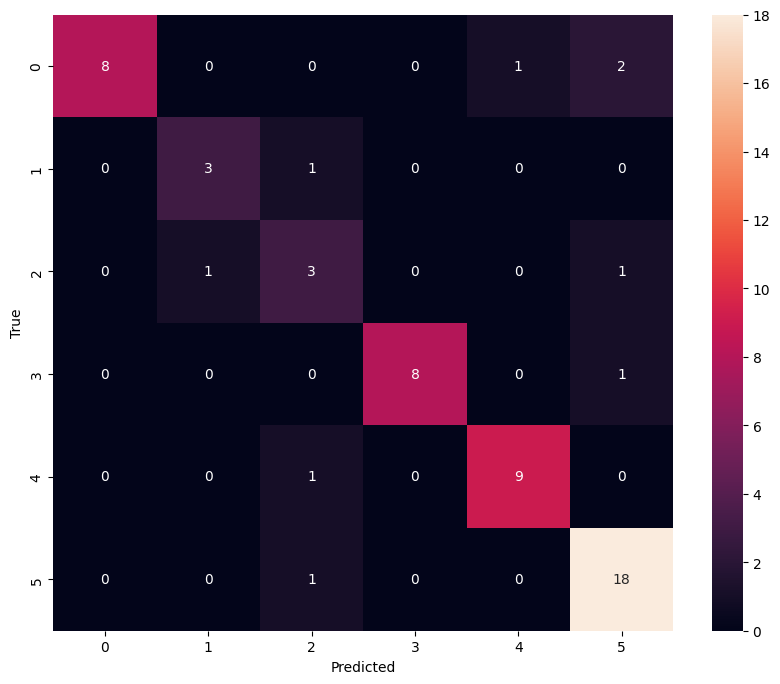

In [151]:
import seaborn as sns

cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

In [126]:
class_dict

{'angelina_jolie': 0,
 'jennifer_lawrence': 1,
 'natalie_portman': 2,
 'nicole_kidman': 3,
 'sandra_bullock': 4,
 'scarlett_johansson': 5}

In [153]:
import joblib

joblib.dump(logReg, 'celeb_model.pkl')

['celeb_model.pkl']

In [154]:
import json

with open('class_dictionary.json', 'w') as f:
    f.write(json.dumps(class_dict))